In [1]:
import pickle
import time
import datetime

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np

import cudf
import cupy

import utils
import arps

# Load in Data

a set of wells from the permian basin are included in parquet format (`wells_permian.parquet`) There are 383970 wells! 

If you have already loaded well data into OmniSci, you can easily read it by using pymapd (https://pymapd.readthedocs.io/en/latest/)

Note: Loading in the data may take a couple minutes


In [2]:
omnisci=False
if omnisci:
    from pymapd import connect

    con = connect(user="abraham", 
                         password="abraham", 
                         host="localhost", 
                         dbname="abraham", 
                         port=6273,
                         protocol='http')

    print(con)

    # if loading in from omnisci:
    l_cols = ['wellapi',
     'state',
     'formationname',
     'subbasin',
     'operator',
     'firstproducingmonth',
     'ProductionPeriodStartDate',
     'ProducingDaysInPeriod',
     'SequentialMonthWell',
     'OilProduced',
     'GasProduced',
     'WaterProduced',
     'CondensateProduced',
     'BOE']
    s_cols = (', ').join(l_cols)

    query = "SELECT " + s_cols + " FROM well WHERE majorbasin='Permian' LIMIT 800000000"
    print(query)

    df_permian = pd.read_sql(query,con)
    df_permian.head()
else:
    permian_all_wells_file = '../data/wells_permian.parquet'
    t0 = time.time()
    df_permian = pd.read_parquet(permian_all_wells_file, engine='pyarrow')
    print("Time to read from parquet: ", time.time()-t0)

Time to read from parquet:  17.201661825180054


In [3]:
df_permian.head()

,wellapi,state,formationname,operator,firstproducingmonth,ProductionPeriodStartDate,ProducingDaysInPeriod,SequentialMonthWell,OilProduced,GasProduced,WaterProduced,CondensateProduced,BOE
0,42-105-35863,TX,HOWARDS CREEK (PENN.),Apache Corporation,1993-01-01,2007-08-01,0.0,176.0,0.000000,0.00,NaN,0.0,0.000000
1,42-103-34006,TX,"EDWARDS -04- (BEND, S.)",V-F Petroleum Inc.,1993-01-01,1999-04-01,30.0,76.0,118.000000,155.00,NaN,0.0,143.832993
2,42-003-01065,TX,FULLERTON,Jm Cox Resources Lp,1993-01-01,2011-01-01,31.0,217.0,400.000000,0.00,NaN,0.0,400.000000
3,42-135-31271,TX,"COWDEN, NORTH",Occidental Petroleum Corp.,1993-11-01,2004-08-01,31.0,130.0,376.119995,0.78,NaN,0.0,376.250000
4,42-135-08546,TX,"GOLDSMITH, W. (CLEAR FORK, UP.)","Aghorn Operating, Inc.",1993-08-01,2016-01-01,31.0,270.0,0.000000,9.85,NaN,0.0,1.641670


In [4]:
start_date = datetime.datetime(2009,1,1)

end_date = datetime.datetime(2016,1,1)

no_wells = len(df_permian['wellapi']
            .loc[(df_permian['firstproducingmonth'] > start_date) & (df_permian['firstproducingmonth'] <= end_date)]
            .unique()
           )
print("Number of wells starting production from %s: %d" %(start_date.year, no_wells))

Number of wells starting production from 2009: 49879


In [5]:
# keep only wells that produce a 'significant' amount of oil (average > 100bpd) and have more than 12 datapoints

bpd = 200

s = df_permian[['wellapi','OilProduced','SequentialMonthWell']].groupby('wellapi').mean()
wells = list(s
             .where(s['OilProduced']>bpd)
             .dropna()
             .index
            )

In [6]:
production_col = 'OilProduced'
datapoints = 18

df_permian_recent = (df_permian[df_permian['wellapi'].isin(wells)]
                     .loc[(df_permian['firstproducingmonth'] > start_date) & (df_permian['firstproducingmonth'] <= end_date)]
                     .sort_values(production_col, ascending=False)
                     .drop_duplicates(['wellapi','SequentialMonthWell'])
                     .dropna(subset=[production_col, 'SequentialMonthWell'])
                     .groupby('wellapi').filter(lambda x: len(x) >= datapoints)
                     .sort_values(['wellapi',production_col],ascending=True)
                 )

well_information = (df_permian_recent[['wellapi','SequentialMonthWell']]
 .groupby(['wellapi'])['SequentialMonthWell']
 .count()
 .reset_index(name='count')
 .sort_values(['count'], ascending=False)
)

well_information.head()

,wellapi,count
272,30-015-36735,87
312,30-015-36805,87
155,30-015-36395,87
199,30-015-36523,87
281,30-015-36752,87


In [7]:
well_information.sort_values(['count'], ascending=True)

,wellapi,count
32077,42-501-36479,18
21156,42-317-39436,18
21164,42-317-39450,18
2541,30-015-40663,18
24083,42-353-33041,18
...,...,...
281,30-015-36752,87
199,30-015-36523,87
155,30-015-36395,87
312,30-015-36805,87


In [8]:
save = False
if save:
    pickle.dump(df_permian_recent, open('../data/permain_oil_wells.p','wb'))

## Quickly viewing n number of random wells

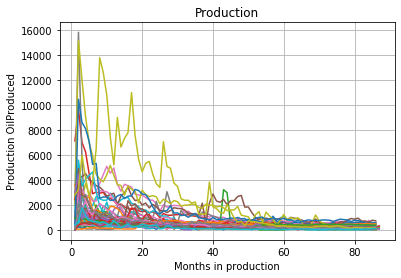

In [9]:
# plot n number of wells together to get an idea of what the production looks like
n = 50

fig, ax = plt.subplots()
#well_apis = df_permian_recent['wellapi'].sample(n)
well_apis = well_information['wellapi'].head(n)
for well_api in well_apis:
    
    well = df_permian_recent.loc[df_permian_recent['wellapi']==well_api].sort_values('SequentialMonthWell',ascending=True)
    ax.plot(well['SequentialMonthWell'],well[production_col])

ax.set(xlabel='Months in production', ylabel='Production '+production_col,
       title='Production')
ax.grid()

plt.show()

# Looking at one well at random

In [10]:
#THIS WELL PICKED AT RANDOM WILL BE USED FOR VALIDATION!
api = np.random.choice(df_permian_recent['wellapi'].unique())
one_well = df_permian_recent[df_permian_recent['wellapi']==api].sort_values('SequentialMonthWell',ascending=True)
print(api)

42-383-38460


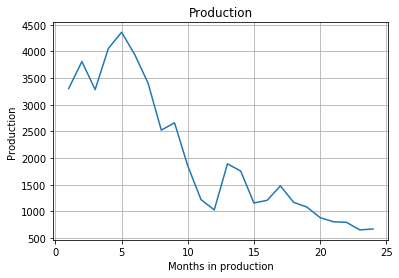

In [11]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(one_well.SequentialMonthWell, one_well[production_col])

ax.set(xlabel='Months in production', ylabel='Production',
       title='Production')
ax.grid()

plt.show()

# Decline curve analysis

In [12]:
interval = 9
qi = arps.max_qi(df=one_well, month_col='SequentialMonthWell', interval=interval, prod=production_col)

popt_exp, pcov_exp = curve_fit(arps.exponential, one_well['SequentialMonthWell'], one_well[production_col],
                               bounds=(0, [qi,20]))

popt_hyp, pcov_hyp = curve_fit(arps.hyperbolic, one_well['SequentialMonthWell'], 
                                    one_well[production_col],bounds=(0, [qi,2,20]))

qi_exp = popt_exp[0]
qi_hyp = popt_hyp[0]
b = popt_hyp[1]
di_exp = popt_exp[1]
di_hyp = popt_hyp[2]
print('Exponential Fit Curve-fitted Variables: qi=%f, di=%f' %(popt_exp[0], popt_exp[1]) )
print('Hyperbolic Fit Curve-fitted Variables: qi=%f, b=%f, di=%f' %(popt_hyp[0], popt_hyp[1], popt_hyp[2]))

one_well.loc[:,'exponential_predicted'] = arps.exponential(one_well['SequentialMonthWell'],*popt_exp)
one_well.loc[:,'hyperbolic_predicted'] = arps.hyperbolic(one_well['SequentialMonthWell'],*popt_hyp)


Exponential Fit Curve-fitted Variables: qi=4359.229980, di=0.070474
Hyperbolic Fit Curve-fitted Variables: qi=4359.229980, b=0.000000, di=0.070478


In [13]:
def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title)
    plt.show()

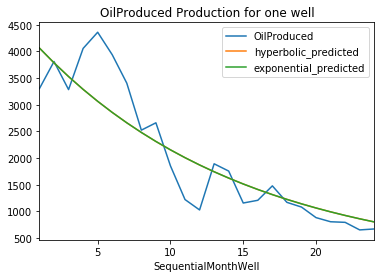

In [14]:
y_variables=[production_col, "hyperbolic_predicted", "exponential_predicted"]
x_variable='SequentialMonthWell'
#Create the plot title
plot_title=production_col+' Production for one well'
#Plot the data to visualize the equation fit
utils.plot_actual_vs_predicted_by_equations(one_well, x_variable, y_variables, plot_title)


# Calculating the values for all wells

In [15]:
# Sequential Arps

def sequential_arps(df):
    """
    Arps calculated sequentially
    """
    grouped = df.groupby('wellapi')

    well_data = []

    t0 = time.time()
    for (name, well) in grouped:
        try:
            well = well.sort_values('SequentialMonthWell',ascending=True)
            qi = arps.max_qi(df=well, month_col='SequentialMonthWell', interval=interval, prod=production_col)

            popt_exp, pcov_exp = curve_fit(arps.exponential, well['SequentialMonthWell'], well[production_col],bounds=(0, [qi,20]))
            popt_hyp, pcov_hyp = curve_fit(arps.hyperbolic, well['SequentialMonthWell'], 
                                                well[production_col],bounds=(0, [qi,2,20]))
            print("Well API: ", name)
            print('Exponential: qi=%f, di=%f' %(popt_exp[0], popt_exp[1]) )
            print('Hyperbolic: qi=%f, b=%f, di=%f' %(popt_hyp[0], popt_hyp[1], popt_hyp[2]))
            print('\n')

            qi = popt_exp[1]
            b = popt_hyp[1]
            di_exp = popt_exp[1]
            di_hyp = popt_hyp[2]

            well_data.append((name, qi, b, di_exp, di_hyp))
        except:
            print("Well %s not forecasted: %f" %(name, qi))
    print("Time: ", time.time()-t0)    
    
    return well_data

In [16]:
def parallel_arps(x):
    try: 
        name = x[0]
        well = x[1]

        well = well.sort_values('SequentialMonthWell',ascending=True)
        qi = arps.max_qi(df=well, month_col='SequentialMonthWell', interval=interval, prod=production_col)

        popt_exp, pcov_exp = curve_fit(arps.exponential, well['SequentialMonthWell'], 
                                       well[production_col],bounds=(0, [qi,20]))
        popt_hyp, pcov_hyp = curve_fit(arps.hyperbolic, well['SequentialMonthWell'], 
                                            well[production_col],bounds=(0, [qi,2,20]))

        #       name, qi_exp,      di_exp,      qi_hyp,      di_hyp,      b
        return (name, popt_exp[0], popt_exp[1], popt_hyp[0], popt_hyp[2], popt_hyp[1])
    except:
        print("Well %s not forecasted: %f" %(name, qi))

In [17]:
# Calculate the arps values for all wells using multiprocessing
from multiprocessing import Pool

grouped = df_permian_recent.groupby('wellapi')
p = Pool()
values = p.map(parallel_arps, [x for x in grouped])
values = [v for v in values if v is not None]

/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 30-025-40461 not forecasted: nan


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 42-003-42429 not forecasted: nan


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 42-003-01172 not forecasted: nan
Well 42-003-01736 not forecasted: nan
Well 42-003-04519 not forecasted: nan
Well 42-003-05520 not forecasted: nan
Well 42-003-30503 not forecasted: nan


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 30-015-36424 not forecasted: nan


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 42-103-02078 not forecasted: nan
Well 42-103-10926 not forecasted: nan


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:776: RuntimeWarning: divide by zero encountered in true_divide
  pcov = np.dot(VT.T / s**2, VT)
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 42-135-33803 not forecasted: nan
Well 42-135-33934 not forecasted: nan
Well 42-135-38734 not forecasted: nan
Well 42-135-39649 not forecasted: 0.000000


/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/minpack.py:693: RuntimeWarning: invalid value encountered in less
  bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:790: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(lb >= ub):
/home/mapdadmin/miniconda3/envs/decline_curve/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:371: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


Well 42-115-30554 not forecasted: nan
Well 42-317-35809 not forecasted: 0.000000
Well 42-353-33250 not forecasted: 0.000000
Well 42-389-32847 not forecasted: 0.000000


In [18]:
save = True
load = True

arps_factors_file = '../data/values.p'

if save:
    import pickle
    pickle.dump(values, open(arps_factors_file,'wb'))

if load:
    values = pickle.load(open(arps_factors_file,'rb'))

In [19]:
# name, qi_exp,      di_exp,      qi_hyp,      di_hyp,      b
df_values = pd.DataFrame(values,columns=['wellapi','qi_exp', 'di_exp', 'qi_hyp', 'di_hyp', 'b'])


In [20]:
# verify results with above
tol = 1e-5
for value in values:
    if value[0] == api:
        result = value
        break

# Sanity Check
assert (result[5] == b) & (result[4] == di_hyp) & (result[3] == qi_hyp) & (result[2] == di_exp) & (result[1] == qi_exp)

In [21]:
# load in data to omnisci
load_wells=False
load_arps=True
from pymapd import connect

con = connect(user="abraham", 
                     password="abraham", 
                     host="localhost", 
                     dbname="abraham", 
                     port=6274,
                     protocol='binary')
if load_wells:
    con.load_table('permian_oil_wells',df_permian_recent)
if load_arps:
    con.load_table('arps_values',df_values)


# Using Built-In UDFs to create Arps curves

In [22]:
query = 'SELECT permian_oil_wells.wellapi, permian_oil_wells.SequentialMonthWell, permian_oil_wells.OilProduced, arps_values.qi_hyp / POWER(1.0 + arps_values.b * arps_values.di_hyp * permian_oil_wells.SequentialMonthWell, 1.0/arps_values.b) as hyperbolic_predicted \
FROM permian_oil_wells \
INNER JOIN arps_values ON permian_oil_wells.wellapi = arps_values.wellapi;'



In [23]:
arps_curves = con.select_ipc(query)

### compare with previous one well example

In [24]:
omni_well = arps_curves[arps_curves['wellapi']==api].sort_values('SequentialMonthWell',ascending=True)

qi_test = arps.max_qi(df=one_well, month_col='SequentialMonthWell', interval=interval, prod=production_col)
popt_hyp, pcov_hyp = curve_fit(arps.hyperbolic, one_well['SequentialMonthWell'], 
                                    one_well[production_col],bounds=(0, [qi,2,20]))
print('Hyperbolic Fit Curve-fitted Variables: qi=%f, b=%f, di=%f' %(popt_hyp[0], popt_hyp[1], popt_hyp[2]))
one_well.loc[:,'hyperbolic_predicted'] = arps.hyperbolic(one_well['SequentialMonthWell'],*popt_hyp)


Hyperbolic Fit Curve-fitted Variables: qi=4359.229980, b=0.000000, di=0.070478


In [29]:
#Sanity check
distance = np.linalg.norm(omni_well.set_index('SequentialMonthWell')['hyperbolic_predicted']- one_well.set_index('SequentialMonthWell')['hyperbolic_predicted'])
assert distance < 1e-5
print(distance)

0.0
